#Transformer

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [2]:
# informer, ARIMA, Prophet, LSTMa와는 다른 형식의 CSV를 사용한다.(Version2)

!pip install pandas


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_NonST_Version2.csv', encoding='cp949')
df.head()

,날짜,2021-02-01 0:00,2021-02-01 1:00,2021-02-01 2:00,2021-02-01 3:00,2021-02-01 4:00,2021-02-01 5:00,2021-02-01 6:00,2021-02-01 7:00,2021-02-01 8:00,2021-02-01 9:00,2021-02-01 10:00,2021-02-01 11:00,2021-02-01 12:00,2021-02-01 13:00,2021-02-01 14:00,2021-02-01 15:00,2021-02-01 16:00,2021-02-01 17:00,2021-02-01 18:00,2021-02-01 19:00,2021-02-01 20:00,2021-02-01 21:00,2021-02-01 22:00,2021-02-01 23:00,2021-02-02 0:00,2021-02-02 1:00,2021-02-02 2:00,2021-02-02 3:00,2021-02-02 4:00,2021-02-02 5:00,2021-02-02 6:00,2021-02-02 7:00,2021-02-02 8:00,2021-02-02 9:00,2021-02-02 10:00,2021-02-02 11:00,2021-02-02 12:00,2021-02-02 13:00,2021-02-02 14:00,...,2021-07-29 9:00,2021-07-29 10:00,2021-07-29 11:00,2021-07-29 12:00,2021-07-29 13:00,2021-07-29 14:00,2021-07-29 15:00,2021-07-29 16:00,2021-07-29 17:00,2021-07-29 18:00,2021-07-29 19:00,2021-07-29 20:00,2021-07-29 21:00,2021-07-29 22:00,2021-07-29 23:00,2021-07-30 0:00,2021-07-30 1:00,2021-07-30 2:00,2021-07-30 3:00,2021-07-30 4:00,2021-07-30 5:00,2021-07-30 6:00,2021-07-30 7:00,2021-07-30 8:00,2021-07-30 9:00,2021-07-30 10:00,2021-07-30 11:00,2021-07-30 12:00,2021-07-30 13:00,2021-07-30 14:00,2021-07-30 15:00,2021-07-30 16:00,2021-07-30 17:00,2021-07-30 18:00,2021-07-30 19:00,2021-07-30 20:00,2021-07-30 21:00,2021-07-30 22:00,2021-07-30 23:00,2021-07-31 0:00
0,종가,82300.0,82300.0,82300.0,82300.0,82300.0,82300.0,82300.0,82300.0,82300.0,82300.0,82300.0,82900.0,82700.0,82800.0,82900.0,82600.0,82600.0,82600.0,82600.0,82600.0,82600.0,82600.0,82600.0,82600.0,82600.0,82600.0,82600.0,82600.0,82600.0,82600.0,82600.0,82600.0,82600.0,82600.0,84800.0,85900.0,85800.0,85300.0,84500.0,...,78500.0,79300.0,78900.0,79100.0,79000.0,78900.0,79100.0,79100.0,79100.0,79100.0,79100.0,79100.0,79100.0,79100.0,79100.0,79100.0,79100.0,79100.0,79100.0,79100.0,79100.0,79100.0,79100.0,79100.0,79100.0,78700.0,78700.0,78600.0,78600.0,78600.0,78600.0,78600.0,78600.0,78600.0,78600.0,78600.0,78600.0,78600.0,78600.0,78600.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Columns: 4322 entries, 날짜 to 2021-07-31 0:00
dtypes: float64(4321), object(1)
memory usage: 33.9+ KB


In [4]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2021-02-01 0:00 to 2021-07-31 0:00


### Train and Validation Series Partioning


In [5]:
######################## CHECK #########################
# 기준시간이 hour이므로, 7일 예측한다면 7*24로 설정한다.


from datetime import timedelta

pred_steps = 24*14+23
pred_length=timedelta(hours = pred_steps)

first_day = pd.to_datetime(data_start_date)
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day
print(val_pred_start, val_pred_end)

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)
print(train_pred_start, train_pred_end)


2021-07-17 01:00:00 2021-07-31 00:00:00
2021-07-02 02:00:00 2021-07-16 01:00:00


In [6]:
enc_length = train_pred_start - first_day
print(enc_length)

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)
print(train_enc_start, train_enc_end)
print(val_enc_start, val_enc_end)

151 days 02:00:00
2021-02-01 00:00:00 2021-07-01 02:00:00
2021-02-15 23:00:00 2021-07-16 01:00:00


In [7]:
# 최종적으로 Val prediction 구간을 예측하게 된다.

print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2021-02-01 00:00:00 - 2021-07-01 02:00:00
Train prediction: 2021-07-02 02:00:00 - 2021-07-16 01:00:00 

Val encoding: 2021-02-15 23:00:00 - 2021-07-16 01:00:00
Val prediction: 2021-07-17 01:00:00 - 2021-07-31 00:00:00

Encoding interval: 151
Prediction interval: 14


## Data Formatting

In [8]:
#np.log 1p 해준다.

date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values.astype(np.float32)
print(series_array)

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1)
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))

    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))    
    
    return series_array

[[82300. 82300. 82300. ... 78600. 78600. 78600.]]


In [9]:
# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)


encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)


# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)

decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)


encoder_input_val_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_val_data, encode_series_mean = transform_series_encode(encoder_input_val_data)

decoder_target_val_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_val_data = transform_series_decode(decoder_target_val_data, encode_series_mean)

#for d in encoder_input_data:
#    print(d.shape)

#train_dataset = tf.data.Dataset.from_tensor_slices((encoder_input_data, decoder_target_data))
#train_dataset = train_dataset.batch(54)

#for d in train_dataset:
#    #print(f'features:{features_tensor} target:{target_tensor}')
#    print("-----")
#    print(d)

### Transformer model

In [10]:
!pip install tensorflow_datasets

import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((encoder_input_data, decoder_target_data))
val_dataset = tf.data.Dataset.from_tensor_slices((encoder_input_val_data, decoder_target_val_data))

In [12]:
### position
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
  
    # apply sin to even indices in the array; 2i
    sines = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    cosines = np.cos(angle_rads[:, 1::2])
  
    pos_encoding = np.concatenate([sines, cosines], axis=-1)
  
    pos_encoding = pos_encoding[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)


In [13]:
# Masking
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions so that we can add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
print(create_padding_mask(x))

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

x = tf.random.uniform((1, 4))
temp = create_look_ahead_mask(x.shape[1])
print(temp)


tf.Tensor(
[[[[0. 0. 1. 1. 0.]]]


 [[[0. 0. 0. 1. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(3, 1, 1, 5), dtype=float32)
tf.Tensor(
[[0. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]], shape=(4, 4), dtype=float32)


In [14]:
# Scaled dot product attention
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.
  
    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth)
        mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.
    
    Returns:
        output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_v, depth)

    return output, attention_weights

In [15]:
# scaled dot product attetion test
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
        q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 3)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [16]:
# Multi Head Attention

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
    
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v) # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size) #(batch_size, num_head, seq_len_v, depth)
        # scaled_attention.shape == (batch_size, num_heads, seq_len_v, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
    
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_v, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_v, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_v, d_model)
        
        return output, attention_weights
    

In [17]:
# multhead attention test
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape


(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [18]:
# activation – the activation function of encoder/decoder intermediate layer, relu or gelu (default=relu).

# Point wise feed forward network
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


In [19]:
# Point wise feed forward network test
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

### Encoder and Decoder

In [20]:
# Encoder Layer
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask) # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1) # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output) # (batch_size, input_seq_len, d_model)
        
        return out2

In [21]:
# Encoder Layer Test
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)


TensorShape([64, 43, 512])

In [22]:
# Decoder Layer
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
                                            
    def call(self, x, enc_output, training,
            look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block1, attn_weights_block2
    
    

In [23]:
# Decoder layer test
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [24]:
# Encoder

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, max_len=5000,
                rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Dense(d_model, use_bias=False)
        self.pos_encoding = positional_encoding(max_len, self.d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        # adding embedding and position encoding
        x = self.embedding(x)
        # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        
        return x
                          

In [25]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048)

sample_encoder_output = sample_encoder(tf.random.uniform((64, 62,1)), 
                                       training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [26]:
# Decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, max_len=5000, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Dense(d_model, use_bias=False)
        self.pos_encoding = positional_encoding(max_len, self.d_model)
    
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training,
                look_ahead_mask, padding_mask):
        
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                  look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
            
        
        
        return x, attention_weights
    


In [27]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048)

output, attn = sample_decoder(tf.random.uniform((64, 26,3)), 
                              enc_output=sample_encoder_output, 
                              training=False, look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

### Transfomer for TS


In [28]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, out_dim, max_len=5000,
                rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                              max_len, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               max_len, rate)
        
        self.final_layer = tf.keras.layers.Dense(out_dim)
        
    def call(self, inp, tar, training, enc_padding_mask,
             look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights
    
    

In [29]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    out_dim=1)

temp_input = tf.random.uniform((64, 62,1))
temp_target = tf.random.uniform((64, 23,1))

fn_out, _ = sample_transformer(temp_input, temp_target,training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape

TensorShape([64, 23, 1])

In [30]:
# Set hyperparameters
# 트랜스포머 기준으로 바꿔볼까? 
# d_model – the number of expected features in the encoder/decoder inputs (default=512).
# nhead – the number of heads in the multiheadattention models (default=8).
# num_encoder_layers – the number of sub-encoder-layers in the encoder & decoder (default=6).
# num_decoder_layers – the number of sub-decoder-layers in the decoder (default=6).
# dff(dim_feedforward) – the dimension of the feedforward network model (default=2048).
# dropout – the dropout value (default=0.1).


num_layers = 1
d_model = 64
dff = 256
num_heads = 8

dropout_rate = 0.1
input_sequence_length = 4320-(24*14+23) # Length of the sequence used by the encoder
target_sequence_length = 24*14+23 # Length of the sequence predicted by the decoder
batch_size = 2**11

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [31]:
# Optimizizer
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [32]:
learning_rate = CustomSchedule(64)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

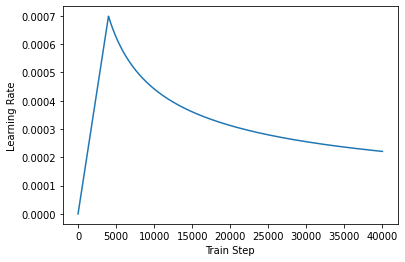

In [33]:
temp_learning_rate_schedule = CustomSchedule(512)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [34]:
# Loss and metrics
loss_object = tf.keras.losses.MeanAbsoluteError()

In [35]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_mean(loss_)


In [36]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
#train_accuracy = tf.keras.metrics.mean_absolute_error()

test_loss = tf.keras.metrics.Mean(name='test_loss')

In [37]:
# Training and checkpoint
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          out_dim=1, rate=dropout_rate)

In [38]:
def create_masks(inp, tar):
    inp = inp.reshape()
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
  
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)
  
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [39]:
# check point
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
    

In [40]:
# EPOCHS
EPOCHS=3000

In [41]:
@tf.function
def train_step(inp, tar):
    last_inp = tf.expand_dims(inp[:,0,:],-1)
    tar_inp = tf.concat([last_inp, tar[:,:-1,:]], axis=1)
    tar_real = tar
  
    #enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    #print(enc_padding_mask)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     None, 
                                     look_ahead_mask, 
                                     None)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    #train_accuracy(tar_real, predictions)

In [42]:
@tf.function
def test_step(inp, tar):
    #print(inp)
    #print(tar)
    last_inp = tf.expand_dims(inp[:,0,:],-1)
    #print(last_inp)
    tar_inp = tf.concat([last_inp, tar[:,:-1,:]], axis=1)
    tar_real = tar
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     False, 
                                     None, 
                                     look_ahead_mask, 
                                     None)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    test_loss(loss)

In [43]:
# Val_dataset을 돌려서 Val_prediction 구간을 예측한다

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    test_loss.reset_states()
    
    # validation:
    for (batch, (inp, tar)) in enumerate(val_dataset):
        #print(inp, tar)
        test_step(inp, tar)
        
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
    #print ('Epoch {} Train Loss {:.4f}'.format(epoch + 1, 
                                                #train_loss.result())) 
                                                #train_accuracy.result()))
    print ('Epoch {} Test Loss {:.4f}'.format(epoch + 1, 
                                                test_loss.result())) 
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
    


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

Epoch 1439 Test Loss 0.0184
Time taken for 1 epoch: 0.04155325889587402 secs

Saving checkpoint for epoch 1440 at ./checkpoints/train/ckpt-288
Epoch 1440 Test Loss 0.0173
Time taken for 1 epoch: 0.12645387649536133 secs

Epoch 1441 Test Loss 0.0151
Time taken for 1 epoch: 0.0426177978515625 secs

Epoch 1442 Test Loss 0.0138
Time taken for 1 epoch: 0.04202699661254883 secs

Epoch 1443 Test Loss 0.0138
Time taken for 1 epoch: 0.04123234748840332 secs

Epoch 1444 Test Loss 0.0161
Time taken for 1 epoch: 0.04165148735046387 secs

Saving checkpoint for epoch 1445 at ./checkpoints/train/ckpt-289
Epoch 1445 Test Loss 0.0163
Time taken for 1 epoch: 0.12374687194824219 secs

Epoch 1446 Test Loss 0.0253
Time taken for 1 epoch: 0.04254269599914551 secs

Epoch 1447 Test Loss 0.0283
Time taken for 1 epoch: 0.04248690605163574 secs

Epoch 1448 Test Loss 0.0177
Time taken for 1 epoch: 0.04161405563354492 secs

Epoch 1449 Test Loss 0.0213
Time taken for 1 epoch: 0.

In [44]:
MAX_LENGTH = target_sequence_length

def evaluate(inp):
    encoder_input = inp
    #print(encoder_input)
    output = tf.expand_dims(encoder_input[:,-1,:],-1)
    #print(output)
    
    for i in range(MAX_LENGTH):
        look_ahead_mask = create_look_ahead_mask(tf.shape(output)[1])
        predictions, attention_weights = transformer(encoder_input, 
                                                     output, 
                                                     False, 
                                                     None, 
                                                     look_ahead_mask, 
                                                     None)
        
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1)
        #print("pred:", predictions) #
        output = tf.concat([output, predictions], axis=1)
        #print(output)
        
    return tf.squeeze(output, axis=0), attention_weights

In [45]:
def mape(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [46]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [47]:
encode_series = encoder_input_val_data[0:1,:,:] 
#print(encode_series)

pred_series, _ = evaluate(encode_series)
pred_series = np.array([pred_series])
encode_series = encode_series.reshape(-1,1)
pred_series = pred_series.reshape(-1,1)[1:,:]   
target_series = decoder_target_val_data[0,:,:1].reshape(-1,1) 

encode_series_tail = np.concatenate([encode_series[-999:],target_series[:1]])
x_encode = encode_series_tail.shape[0]

print(mape(pred_series[:24*14+23-23]*80846+81652.04075, target_series*80846+81652.04075))

print(mean_squared_error(target_series*80846+81652.04075, pred_series[:24*14+23-23]*80846+81652.04075))

print(mean_absolute_error(target_series*80846+81652.04075, pred_series[:24*14+23-23]*80846+81652.04075))

0.6826749350328923
426880.1104418241
539.4555407155173


In [48]:
x_encode

1000

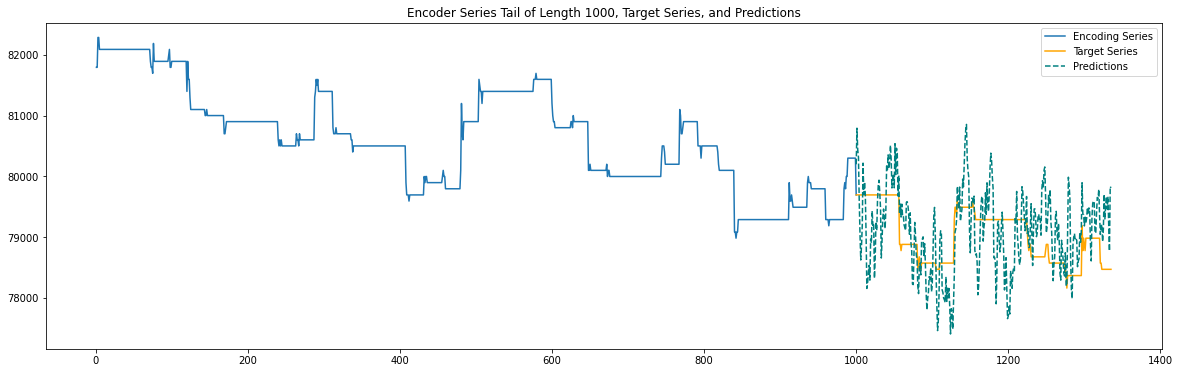

In [49]:
# 실제와 가격차이가 어떻게 나는지 비교해서 보정한다.

plt.figure(figsize=(20,6))   

plt.plot(range(1,x_encode+1),encode_series_tail*80846+81652.04075)
plt.plot(range(x_encode,x_encode+pred_steps-23),target_series*80846+81652.04075,color='orange')
plt.plot(range(x_encode,x_encode+pred_steps-23),pred_series[:24*14+23-23]*80846+81652.04075,color='teal',linestyle='--')


plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % 1000)
plt.legend(['Encoding Series','Target Series','Predictions'])

#Prophet

In [50]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import numpy as np

In [51]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_NonST_Version1.csv", encoding='CP949')
df = df.drop(df.columns[0], axis=1)

df.columns = ["ds","y"]
df["ds"] = pd.to_datetime(df["ds"], dayfirst = True)

df.head()

,ds,y
0,2021-02-01 00:00:00,82300.0
1,2021-02-01 01:00:00,82300.0
2,2021-02-01 02:00:00,82300.0
3,2021-02-01 03:00:00,82300.0
4,2021-02-01 04:00:00,82300.0


In [52]:
m = Prophet()
m.fit(df[:-24*14])

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [53]:
future = m.make_future_dataframe(freq='H',periods=24*14)
future.tail()

,ds
4316,2021-07-30 20:00:00
4317,2021-07-30 21:00:00
4318,2021-07-30 22:00:00
4319,2021-07-30 23:00:00
4320,2021-07-31 00:00:00


In [54]:
forecast = m.predict(future)
forecast[['ds', 'yhat']].tail()

,ds,yhat
4316,2021-07-30 20:00:00,79270.880003
4317,2021-07-30 21:00:00,79271.010085
4318,2021-07-30 22:00:00,79270.637541
4319,2021-07-30 23:00:00,79265.904443
4320,2021-07-31 00:00:00,79257.961370


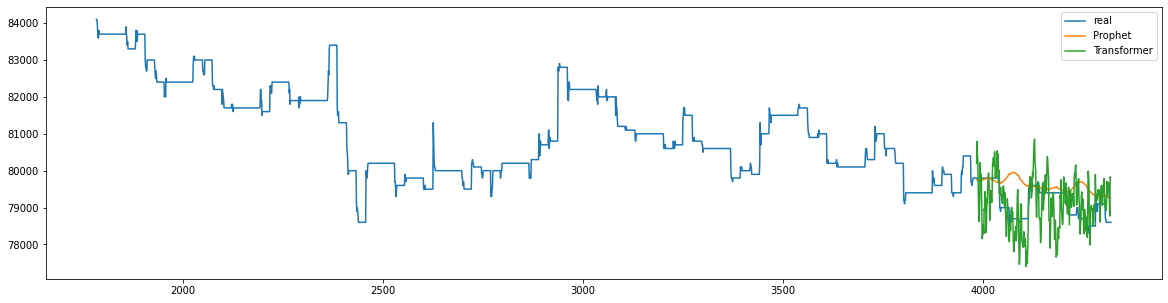

In [55]:
plt.figure(figsize=(20,5))

plt.plot(df["y"][1784:], label="real")
plt.plot(range(4320-24*14,4320),forecast['yhat'][-24*14:], label="Prophet")
plt.plot(range(4320-24*14,4320),pred_series[:24*14+23-23]*80846+81652.04075, label="Transformer")
plt.legend()
plt.show()

#LSTMa

In [56]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from tqdm import trange
import random

In [57]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_NonST_Version1.csv", encoding='CP949')

data.head()

,Unnamed: 0,날짜,종가
0,0,2021-02-01 00:00:00,82300.0
1,1,2021-02-01 01:00:00,82300.0
2,2,2021-02-01 02:00:00,82300.0
3,3,2021-02-01 03:00:00,82300.0
4,4,2021-02-01 04:00:00,82300.0


In [58]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
data["종가"] = min_max_scaler.fit_transform(data["종가"].to_numpy().reshape(-1,1))

In [59]:
train = data[:-24*14]
train = train["종가"].to_numpy()

test = data[-24*14:]
test = test["종가"].to_numpy()

In [60]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda", index=0)

In [61]:
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

In [62]:
class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        output = self.linear(lstm_out)
        
        return output, self.hidden

In [63]:
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs

    def predict(self, inputs, target_len):
        inputs = inputs.unsqueeze(0)
        self.eval()
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

In [64]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [65]:
iw = 24*28
ow = 24*14

train_dataset = windowDataset(train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)
# y_train_loader = DataLoader(y_train, batch_size=5)

In [66]:
model = lstm_encoder_decoder(input_size=1, hidden_size=16).to(device)
# model.train_model(X_train.to(device), y_train.to(device), n_epochs=100, target_len=ow, batch_size=5, training_bprediction="mixed_teacher_forcing", teacher_forcing_ratio=0.6, learning_rate=0.01, dynamic_tf=False)

In [67]:
#5000으로 할 경우 시간도 오래걸리고 에러도 커서 100으로 줄인다.

learning_rate=0.01
epoch = 100
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [68]:
from tqdm import tqdm

model.train()
with tqdm(range(epoch)) as tr:
    for i in tr:
        total_loss = 0.0
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model(x, y, ow, 0.6).to(device)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

100%|██████████| 100/100 [25:00<00:00, 15.00s/it, loss=0.00062]


In [69]:
predict = model.predict(torch.tensor(train_dataset[0][0]).to(device).float(), target_len=ow)
real = train_dataset[0][1]

In [70]:
predict = model.predict(torch.tensor(train[-24*14*2:]).reshape(-1,1).to(device).float(), target_len=ow)
real = data["종가"].to_numpy()

predict = min_max_scaler.inverse_transform(predict.reshape(-1,1))
real = min_max_scaler.inverse_transform(real.reshape(-1,1))

In [71]:
real.shape

(4321, 1)

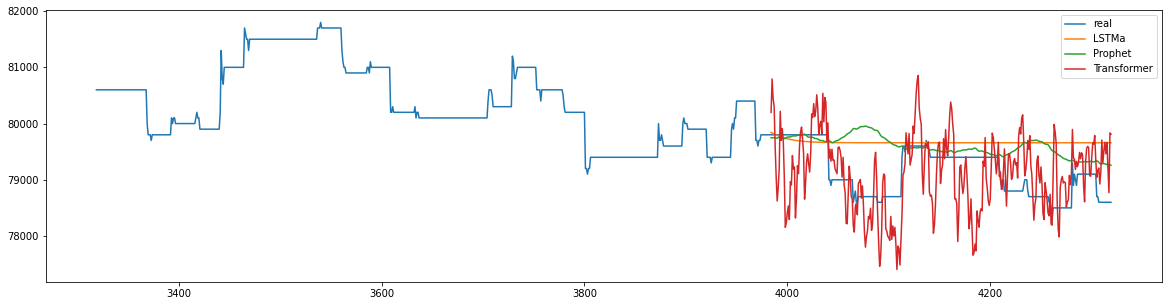

In [72]:
plt.figure(figsize=(20,5))
plt.plot(range(3319,4320), real[3320:], label="real")
plt.plot(range(4320-24*14,4320), predict[-24*14:], label="LSTMa")
plt.plot(range(4320-24*14,4320),forecast['yhat'][-24*14:], label="Prophet")
plt.plot(range(4320-24*14,4320),pred_series[:24*14+23-23]*80846+81652.04075, label="Transformer")

plt.legend()
plt.show()

#Informer

In [73]:
!git clone https://github.com/zhouhaoyi/Informer2020.git

Cloning into 'Informer2020'...
remote: Enumerating objects: 535, done.
remote: Total 535 (delta 0), reused 0 (delta 0), pack-reused 535
Receiving objects: 100% (535/535), 6.47 MiB | 20.33 MiB/s, done.
Resolving deltas: 100% (306/306), done.


In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from datetime import timedelta
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
from models.model import Informer

In [77]:
class StandardScaler():
    def __init__(self):
        self.mean = 0.
        self.std = 1.
    
    def fit(self, data):
        self.mean = data.mean(0)
        self.std = data.std(0)

    def transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data - mean) / std

    def inverse_transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data * std) + mean
        

def time_features(dates, freq='h'):
    dates['month'] = dates.date.apply(lambda row:row.month,1)
    dates['day'] = dates.date.apply(lambda row:row.day,1)
    dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
    dates['hour'] = dates.date.apply(lambda row:row.hour,1)
    dates['minute'] = dates.date.apply(lambda row:row.minute,1)
    dates['minute'] = dates.minute.map(lambda x:x//15)
    freq_map = {
        'y':[],'m':['month'],'w':['month'],'d':['month','day','weekday'],
        'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
        't':['month','day','weekday','hour','minute'],
    }
    return dates[freq_map[freq.lower()]].values

def _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float()
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)
    dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
    dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float().to(device)
    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    batch_y = batch_y[:,-pred_len:,0:].to(device)
    return outputs, batch_y

In [78]:
class Dataset_Pred(Dataset):
    def __init__(self, dataframe, size=None, scale=True):
        self.seq_len = size[0]
        self.label_len = size[1]
        self.pred_len = size[2]
        self.dataframe = dataframe
        
        self.scale = scale
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = self.dataframe
        df_raw["date"] = pd.to_datetime(df_raw["date"])

        delta = df_raw["date"].iloc[1] - df_raw["date"].iloc[0]
        if delta>=timedelta(hours=1):
            self.freq='h'
        else:
            self.freq='t'

        

        border1 = 0
        border2 = len(df_raw)
        cols_data = df_raw.columns[1:]
        df_data = df_raw[cols_data]


        if self.scale:
            self.scaler.fit(df_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
            
        tmp_stamp = df_raw[['date']][border1:border2]
        tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
        pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
        
        df_stamp = pd.DataFrame(columns = ['date'])
        df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
        data_stamp = time_features(df_stamp, freq=self.freq)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]
        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

In [79]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_NonST_Version1.csv", encoding='CP949')

data.head()

,Unnamed: 0,날짜,종가
0,0,2021-02-01 00:00:00,82300.0
1,1,2021-02-01 01:00:00,82300.0
2,2,2021-02-01 02:00:00,82300.0
3,3,2021-02-01 03:00:00,82300.0
4,4,2021-02-01 04:00:00,82300.0


In [80]:
data["date"] = data["날짜"]
data["date"] = pd.to_datetime(data["date"], dayfirst = True)
data["value"] = data["종가"]

min_max_scaler = MinMaxScaler()
data["value"] = min_max_scaler.fit_transform(data["value"].to_numpy().reshape(-1,1)).reshape(-1)
data = data[["date", "value"]]

data_train = data.iloc[:-24*14].copy()

In [81]:
pred_len = 24*14

seq_len = pred_len#인풋 크기
label_len = pred_len#디코더에서 참고할 크기
pred_len = pred_len#예측할 크기

batch_size = 10
shuffle_flag = True
num_workers = 0
drop_last = True



dataset = Dataset_Pred(dataframe=data_train ,scale=True, size = (seq_len, label_len,pred_len))
data_loader = DataLoader(dataset,batch_size=batch_size,shuffle=shuffle_flag,num_workers=num_workers,drop_last=drop_last)

In [82]:
enc_in = 1
dec_in = 1
c_out = 1
device = torch.device("cuda:0")

model = Informer(enc_in, dec_in, c_out, seq_len, label_len, pred_len, device = device).to(device)
learning_rate = 1e-4
criterion =  nn.MSELoss()

model_optim = optim.Adam(model.parameters(), lr=learning_rate)

In [83]:
# Informer는 error를 100하는게 시간도 덜 걸리고 에러도 적다.

train_epochs = 100
model.train()
progress = tqdm(range(train_epochs))
for epoch in progress:
    train_loss = []
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
        model_optim.zero_grad()
        pred, true = _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark)
        loss = criterion(pred, true)
        train_loss.append(loss.item())
        loss.backward()
        model_optim.step()
    train_loss = np.average(train_loss)
    progress.set_description("loss: {:0.6f}".format(train_loss))

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning:

Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)

loss: 0.006309: 100%|██████████| 100/100 [1:03:57<00:00, 38.37s/it]


In [84]:
import time
now = time.time()
scaler = dataset.scaler
df_test = data_train.copy()
df_test["value"] = scaler.transform(df_test["value"])
df_test["date"] = pd.to_datetime(df_test["date"].values)

delta = df_test["date"][1] - df_test["date"][0]
for i in range(pred_len):
    df_test = df_test.append({"date":df_test["date"].iloc[-1]+delta}, ignore_index=True)
df_test = df_test.fillna(0)


df_test_x = df_test.iloc[-seq_len-pred_len:-pred_len].copy()
df_test_y = df_test.iloc[-label_len-pred_len:].copy()

df_test_numpy = df_test.to_numpy()[:,1:].astype("float")
test_time_x = time_features(df_test_x, freq=dataset.freq) #인풋 타임 스템프
test_data_x = df_test_numpy[-seq_len-pred_len:-pred_len] #인풋 데이터


test_time_y = time_features(df_test_y, freq=dataset.freq) #아웃풋 타임스템프
test_data_y =df_test_numpy[-label_len-pred_len:]
test_data_y[-pred_len:] = np.zeros_like(test_data_y[-pred_len:]) #예측하는 부분을 0으로 채워준다.



test_time_x = test_time_x
test_time_y = test_time_y
test_data_y = test_data_y.astype(np.float64)
test_data_x = test_data_x.astype(np.float64)

_test = [(test_data_x,test_data_y,test_time_x,test_time_y)]
_test_loader = DataLoader(_test,batch_size=1,shuffle=False)

preds = []

with torch.no_grad():
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(_test_loader):
        
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)

        batch_x_mark = batch_x_mark.float().to(device)
        batch_y_mark = batch_y_mark.float().to(device)

        outputs = model(batch_x, batch_x_mark, batch_y, batch_y_mark)
        preds = outputs.detach().cpu().numpy()

preds = scaler.inverse_transform(preds[0])

df_test.iloc[-pred_len:, 1:] = preds
print(time.time() - now)

1.0728051662445068


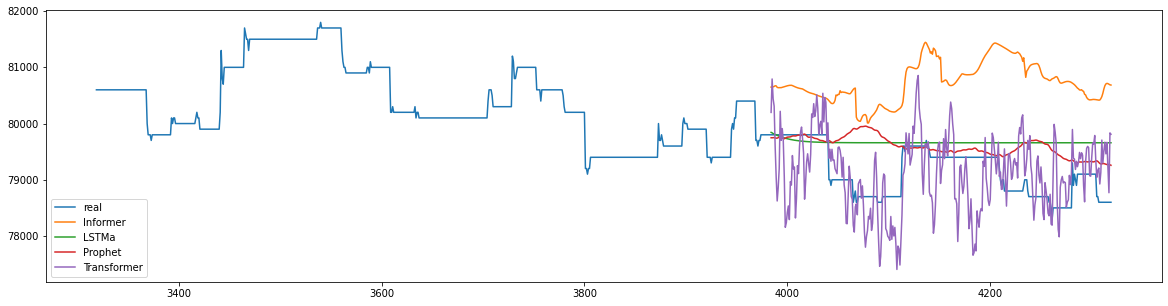

In [85]:
import matplotlib.pyplot as plt

real = data["value"].to_numpy()
result = df_test["value"].iloc[-24*14:].to_numpy()

real = min_max_scaler.inverse_transform(real.reshape(-1,1)).reshape(-1)
result = min_max_scaler.inverse_transform(result.reshape(-1,1)).reshape(-1)

plt.figure(figsize=(20,5))
plt.plot(range(3319,4320),real[3320:], label="real")
plt.plot(range(4320-24*14,4320),result, label="Informer")
plt.plot(range(4320-24*14,4320), predict[-24*14:], label="LSTMa")
plt.plot(range(4320-24*14,4320),forecast['yhat'][-24*14:], label="Prophet")
plt.plot(range(4320-24*14,4320),pred_series[:24*14+23-23]*80846+81652.04075, label="Transformer")

plt.legend()
plt.show()


#ARIMA

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [87]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_NonST_Version1.csv", encoding='CP949')
df = df.drop(df.columns[0], axis=1)
df.columns = ["ds","y"]
df.head()

,ds,y
0,2021-02-01 00:00:00,82300.0
1,2021-02-01 01:00:00,82300.0
2,2021-02-01 02:00:00,82300.0
3,2021-02-01 03:00:00,82300.0
4,2021-02-01 04:00:00,82300.0


In [88]:
df_train = df.iloc[:-24*14]

In [89]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



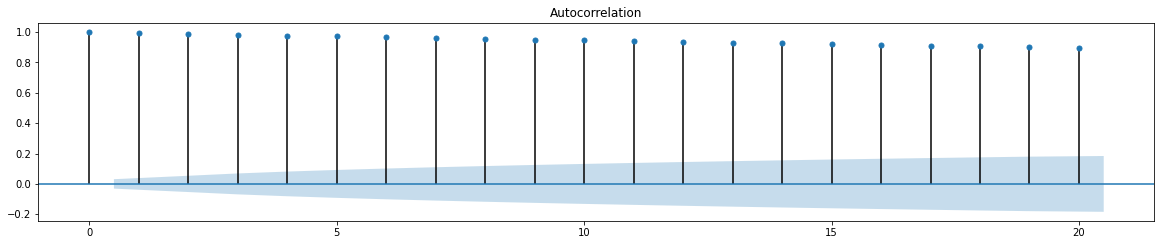

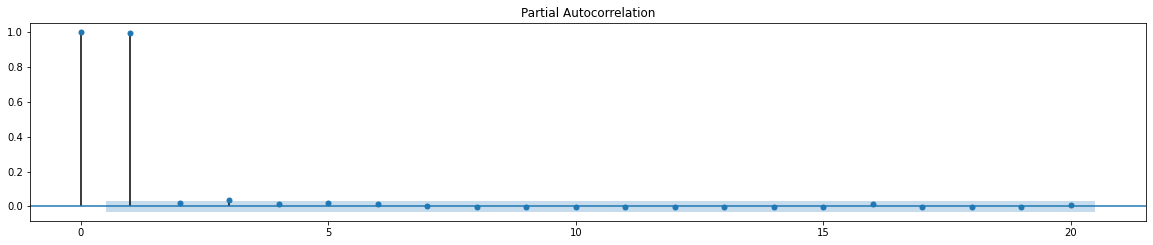

In [90]:
import statsmodels.api as sm
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train["y"], lags=20, ax=ax1)

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train["y"], lags=20, ax=ax1)

In [91]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from tqdm import tqdm

In [92]:
p = range(0,3)
d = range(1,2)
q = range(0,6)
m = 24

pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1], x[2], m) for x in list(itertools.product(p,d,q))]

aic = []
params = []

with tqdm(total = len(pdq) * len(seasonal_pdq)) as pg:
    for i in pdq:
        for j in seasonal_pdq:
            pg.update(1)
            try:
                model = SARIMAX(df_train["y"], order=(i), season_order = (j))
                model_fit = model.fit()
                # print("SARIMA:{}{}, AIC:{}".format(i,j, round(model_fit.aic,2)))
                aic.append(round(model_fit.aic,2))
                params.append((i,j))
            except:
                continue

100%|██████████| 324/324 [02:35<00:00,  2.08it/s]


In [93]:
optimal = [(params[i],j) for i,j in enumerate(aic) if j == min(aic)]
model_opt = SARIMAX(df_train["y"], order = optimal[0][0][0], seasonal_order = optimal[0][0][1])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3985
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 24)   Log Likelihood              -27186.910
Date:                            Thu, 30 Sep 2021   AIC                          54379.820
Time:                                    08:04:54   BIC                          54398.672
Sample:                                         0   HQIC                         54386.506
                                           - 3985                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9478      0.004    266.829      0.000       0.941       0.955
ma.L1         -0.9997      0.003   -286.381      0.000      -1.007      -0.993
sigma2      5.353e+04    347.454    154.059      0.000    5.28e+04    5.42e+04
===================================================================================
Ljung-Box (Q):                      957.69   Jarque-Bera (JB):            578464.62
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -1.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        62.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



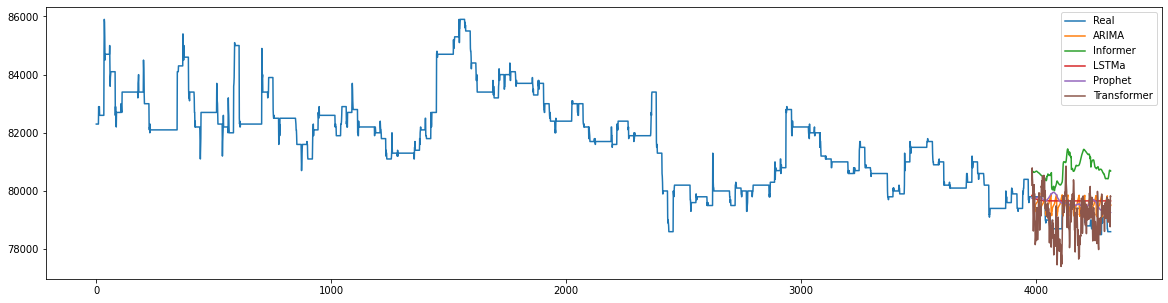

In [94]:
model = SARIMAX(df_train["y"], order=optimal[0][0][0], seasonal_order=optimal[0][0][1])
model_fit = model.fit(disp=0)
ARIMA_forecast = model_fit.forecast(steps=24*14)

plt.figure(figsize=(20,5))
plt.plot(range(0,4320), df["y"].iloc[1:], label="Real")

plt.plot(ARIMA_forecast, label="ARIMA")
plt.plot(range(4320-24*14,4320),result, label="Informer")
plt.plot(range(4320-24*14,4320), predict[-24*14:], label="LSTMa")
plt.plot(range(4320-24*14,4320),forecast['yhat'][-24*14:], label="Prophet")
plt.plot(range(4320-24*14,4320),pred_series[:24*14+23-23]*80846+81652.04075, label="Transformer")

plt.legend()
plt.show()

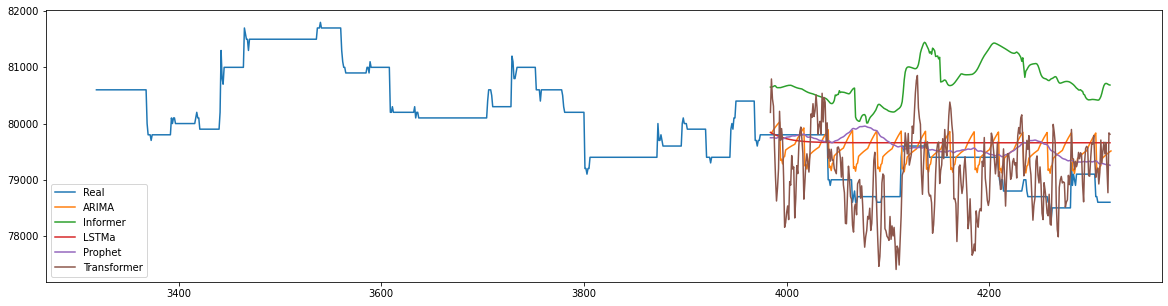

In [95]:
plt.figure(figsize=(20,5))
plt.plot(range(3319,4320), df["y"].iloc[3320:], label="Real")

plt.plot(ARIMA_forecast, label="ARIMA")
plt.plot(range(4320-24*14,4320),result, label="Informer")
plt.plot(range(4320-24*14,4320), predict[-24*14:], label="LSTMa")
plt.plot(range(4320-24*14,4320),forecast['yhat'][-24*14:], label="Prophet")
plt.plot(range(4320-24*14,4320),pred_series[:24*14+23-23]*80846+81652.04075, label="Transformer")

plt.legend()
plt.show()

In [96]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MSE(y_true, y_pred):
    return np.mean(np.square((y_true - y_pred)))

def MAE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred)))



print('Transformer')
print('-' * 40)
print('MAPE: {} |\nMSE: {} |\nMAE : {}\n'.format(mape(pred_series[:24*14+23-23]*80846+81652.04075, target_series*80846+81652.04075), mean_squared_error(target_series*80846+81652.04075, pred_series[:24*14+23-23]*80846+81652.04075), mean_absolute_error(target_series*80846+81652.04075, pred_series[:24*14+23-23]*80846+81652.04075)))

print('Informer')
print('-' * 40)
print('MAPE: {} |\nMSE: {} |\nMAE : {}\n'.format(mape(result, real[-24*14:]), mean_squared_error(real[-24*14:], result), mean_absolute_error(real[-24*14:], result)))

print('ARIMA')
print('-' * 40)
print('MAPE: {} |\nMSE: {} |\nMAE : {}\n'.format(mape(ARIMA_forecast, df["y"].iloc[-24*14:]), mean_squared_error(df["y"].iloc[-24*14:], ARIMA_forecast), mean_absolute_error(df["y"].iloc[-24*14:], ARIMA_forecast)))

print('Prophet')
print('-' * 40)
print('MAPE: {} |\nMSE: {} |\nMAE : {}\n'.format(mape(forecast['yhat'][4320-24*14:],df["y"][4320-24*14:]), mean_squared_error(df["y"][4320-24*14:], forecast['yhat'][4320-24*14:]), mean_absolute_error(df["y"][4320-24*14:], forecast['yhat'][4320-24*14:])))

print('LSTMa')
print('-' * 40)
print('MAPE: {} |\nMSE: {} |\nMAE : {}\n'.format(mape(predict[-24*14:],real[-24*14:]),  mean_squared_error(real[-24*14:], predict[-24*14:]), mean_absolute_error(real[-24*14:], predict[-24*14:])))

Transformer
----------------------------------------
MAPE: 0.6826749350328923 |
MSE: 426880.1104418241 |
MAE : 539.4555407155173

Informer
----------------------------------------
MAPE: 2.016332828662477 |
MSE: 2797640.5582507337 |
MAE : 1593.7206789410181

ARIMA
----------------------------------------
MAPE: 0.616589544522498 |
MSE: 355200.1868074745 |
MAE : 486.4291066741278

Prophet
----------------------------------------
MAPE: 0.5994651992486683 |
MSE: 406185.788038957 |
MAE : 472.2801966222579

LSTMa
----------------------------------------
MAPE: 0.7193599765038883 |
MSE: 457714.1235429673 |
MAE : 552.8678152901786

